# Return Prediction


 ### **Goal:** Predicting Stock returns using Neural Networks.

 We will be using the following Data Set: sp500.csv.gz

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('sp500.csv.gz', index_col=0)
df

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,...,NaN,0.004522,0.005959,0.012615,0.022213,0.040947,0.017747,-0.002773,0.015421,0.012176
2006-01-04,0.002687,0.005686,0.001467,-0.006626,0.001517,-0.009794,0.009264,0.003238,-0.005951,-0.005013,...,NaN,0.024160,0.004847,0.020519,0.044610,0.001710,-0.001341,0.008556,0.009492,0.007061
2006-01-05,0.026198,0.007981,0.013669,-0.012387,0.010856,-0.009110,0.031857,-0.008391,-0.014722,-0.008527,...,NaN,-0.008791,-0.000536,-0.001867,0.060566,-0.004951,-0.010745,0.042630,-0.010560,0.009089
2006-01-06,0.005222,-0.003299,0.040453,-0.011095,0.021229,0.024429,0.003925,0.008679,0.057798,0.014660,...,NaN,0.001478,0.003753,0.001583,0.019615,0.019732,-0.006110,-0.002848,-0.005117,0.010422
2006-01-09,-0.002886,0.011255,0.004860,0.000000,0.037173,-0.015641,0.014073,-0.002581,-0.014676,-0.004816,...,NaN,-0.002362,-0.002671,0.006752,-0.000687,-0.000505,0.013661,0.007752,0.035415,-0.008277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.017029,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,-0.007700,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.015034,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138


## I. Simple Test/Val/Train for starters

### 1. Using the first 1000 time steps of the data, train a GRU to predict the returns of the N assets based on the sequence of their past returns. Use EarlyStopping.

In [5]:
# Data Preparation
N_ASSETS = 100      # We restrain our analysis to 100 tickers
SEQ_LENGTH = 20    # Length of the history window (T_seq)
LIMIT = 1000       # We only use the first 1000 time steps

def create_sequences(data, seq_length):
    """
    Transforms a 2D array (T, N) into a 3D tensor input (Samples, seq_len, N)
    and a full sequence 2D target matrix (Samples, N).
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)] # The sequence of past returns
        y = data[i + seq_length]     # The target returns at t
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Fill NaN and Inf values in the original dataframe before subsetting
df_filled = df.fillna(0).replace([np.inf, -np.inf], np.nan).fillna(0)

# We keep the 1000 first time steps from the filled dataframe, and select the first N_ASSETS columns
data_subset = df_filled.iloc[:LIMIT, :N_ASSETS].values.astype('float32')

# Train/Validation 80%/20%
X, y = create_sequences(data_subset, SEQ_LENGTH)

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Input Shape: {X_train.shape}")  # Should be (Samples, SEQ_LEN, N_ASSETS)
print(f"Target Shape: {y_train.shape}") # Should be (Samples, N_ASSETS)


Input Shape: (784, 20, 100)
Target Shape: (784, 100)


In [6]:
model = Sequential()

# GRU Layer
model.add(GRU(units=64, input_shape=(SEQ_LENGTH, N_ASSETS), activation='tanh')) # 64 neurons just to start
model.add(Dense(N_ASSETS, activation='linear')) # We are using a 'linear' activation continuous regression output that can be both negatve/positive.

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,372 (149.89 KB)

 Trainable params: 38,372 (149.89 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training with EarlyStopping

# "Use EarlyStopping" which stops training when validation loss stops improving for 5 consecutive epochs to prevent overfitting.
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[es],
                    verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.0877e-04 - val_loss: 9.5070e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3434e-04 - val_loss: 9.2991e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2917e-04 - val_loss: 9.2333e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1709e-04 - val_loss: 9.1656e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9120e-04 - val_loss: 9.2552e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8288e-04 - val_loss: 9.1367e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9989e-04 - val_loss: 9.1111e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8365e-04 - val_loss: 9.2360e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8467e-04 - val_loss: 9.3357e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3761e-04 - val_loss: 9.6655e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3404e-04 - val_lo

### 2. Measure the Kendall correlation between the true returns and the predicted returns over the test period. Also indicate the p-value.

This correlation rank the tickers returns one compared to another.

In [8]:
from scipy.stats import kendalltau

# Prepare the Test Data
test_start_index = LIMIT - SEQ_LENGTH
data_test_subset = df_filled.iloc[test_start_index:, :N_ASSETS].values.astype('float32')

# Create sequences for the test set using the same function as before
X_test, y_test = create_sequences(data_test_subset, SEQ_LENGTH)

In [9]:
# Prediction
y_pred = model.predict(X_test)

# Calculate Kendall correlation
tau, p_value = kendalltau(y_test.flatten(), y_pred.flatten())

print(f"Kendall Correlation (Tau) : {tau:.5f}")
print(f"P-value                   : {p_value:.5e}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Kendall Correlation (Tau) : 0.01131
P-value                   : 4.23310e-15


This model gives a very low Kendall's correlation, 0.01 would be our benchmark to evaluate the future models/added features performance.

### 3. Does this correlation increase if the number of neurons in the GRU is increased?

We will proceed using grid search in order to find a rough estimate of the number of neurones we should have for GRU:

In [10]:
neuron_grid = [32, 64, 128, 256, 512]
results = {}

for n_neurons in neuron_grid:
    print(f"\n--- Test with {n_neurons} neurons ---")

    # Model
    model = Sequential()
    model.add(GRU(units=n_neurons, input_shape=(SEQ_LENGTH, N_ASSETS), activation='tanh'))
    model.add(Dense(N_ASSETS, activation='tanh'))
    model.compile(optimizer='adam', loss='mse')

    # Training
    # We use early stopping to save time
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=30,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[es],
              verbose=0)

    # Evaluation
    y_pred = model.predict(X_test, verbose=0)
    tau, _ = kendalltau(y_test.flatten(), y_pred.flatten())

    results[n_neurons] = tau
    print(f"-> Result : Kendall Correlation = {tau:.5f}")


--- Test avec 32 neurones ---
-> Résultat : Kendall Correlation = 0.01047

--- Test avec 64 neurones ---
-> Résultat : Kendall Correlation = 0.00986

--- Test avec 128 neurones ---
-> Résultat : Kendall Correlation = 0.00451

--- Test avec 256 neurones ---
-> Résultat : Kendall Correlation = 0.01253

--- Test avec 512 neurones ---
-> Résultat : Kendall Correlation = 0.00424


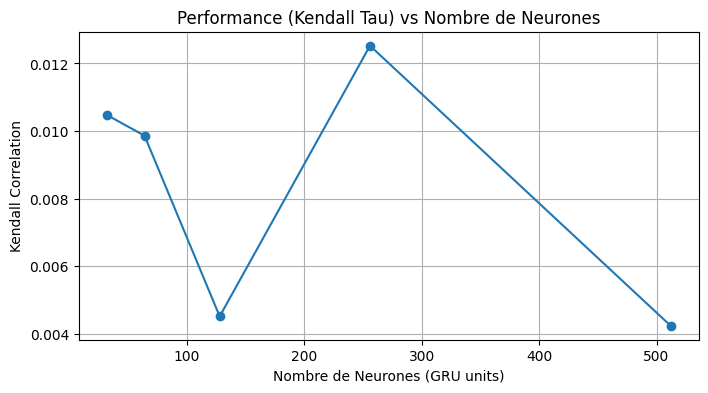

In [11]:
# Small graph for visualization
best_neurone_nb_gru = max(results, key=results.get) #Best value for future testing

plt.figure(figsize=(8, 4))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='-')
plt.title("Performance (Kendall Tau) vs Number of Neurons")
plt.xlabel("Number of Neurons (GRU units)")
plt.ylabel("Kendall Correlation")
plt.grid(True)
plt.show()

The Kendall Correlation increased slightly for 256 neuronnes, despite the further increase of the number of neurones, the performance drops. The financial returns countains a lot of noice so there is a high chance our model overfits past 256 neuronnes.

#### 4. Does an LSTM perform better than a GRU?

In [13]:
from tensorflow.keras.layers import LSTM

In [14]:
neuron_grid = [32, 64, 128, 256, 512]
results_lstm = {}

for n_neurons in neuron_grid:
    print(f"\n--- Test LSTM avec {n_neurons} neurones ---")

    # Model
    model = Sequential()
    model.add(LSTM(units=n_neurons, input_shape=(SEQ_LENGTH, N_ASSETS), activation='tanh'))
    model.add(Dense(N_ASSETS, activation='linear'))
    model.compile(optimizer='adam', loss='mse')

    # Training
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=30,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[es],
              verbose=0)

    # Evaluation
    y_pred = model.predict(X_test, verbose=0)
    tau, _ = kendalltau(y_test.flatten(), y_pred.flatten())

    results_lstm[n_neurons] = tau
    print(f"-> Résultat LSTM : Kendall Correlation = {tau:.5f}")


--- Test LSTM avec 32 neurones ---
-> Résultat LSTM : Kendall Correlation = 0.01095

--- Test LSTM avec 64 neurones ---
-> Résultat LSTM : Kendall Correlation = 0.00880

--- Test LSTM avec 128 neurones ---
-> Résultat LSTM : Kendall Correlation = 0.00786

--- Test LSTM avec 256 neurones ---
-> Résultat LSTM : Kendall Correlation = 0.00939

--- Test LSTM avec 512 neurones ---
-> Résultat LSTM : Kendall Correlation = 0.01282


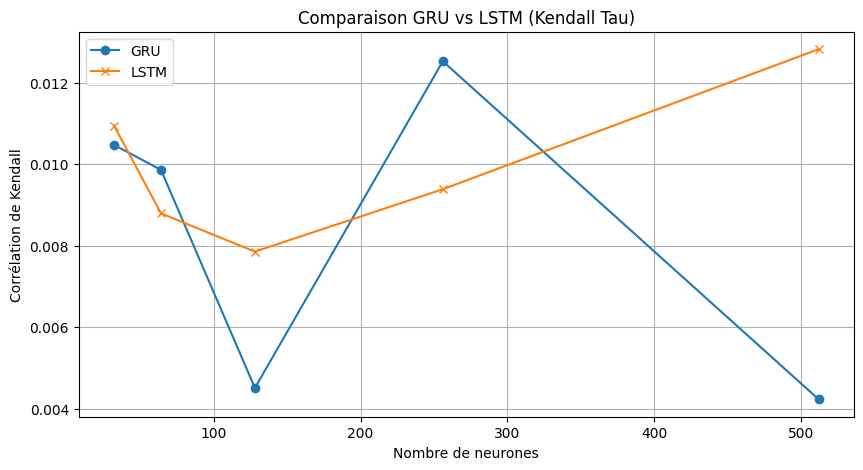

In [15]:
# Graphical Comparison
best_neurone_nb_lstm = max(results_lstm, key=results_lstm.get) #Best value for future testing

if 'results' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(list(results.keys()), list(results.values()), marker='o', label='GRU')
    plt.plot(list(results_lstm.keys()), list(results_lstm.values()), marker='x', label='LSTM')
    plt.title("Comparaison GRU vs LSTM (Kendall Tau)")
    plt.xlabel("Number of neurons")
    plt.ylabel("Kendall Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nBest LSTM result :", max(results_lstm.values()))

In [16]:
print(best_neurone_nb_lstm)

512


We observe that the LSTM Model provide better results but only using more  than 500 neurones. This is beacause LSTM is more complex than GRU.

### 5. Now add a RevIN layer at the input of the RNN and the same layer (in 'denorm' mode) before the output of the RNN. Did the Kendall correlation increase? Was it significant?

Usually, data is normalized (global mean subtracted and divided by global standard deviation) at the very beginning of the code. However, since the mean and variance change over time, this global normalization is not sufficient. The idea of RevIN is to normalize 'on the fly', sequence by sequence instead.

Just before entering the RNN, we calculate the mean (μ) and standard deviation (σ) of that specific 20-day window. We then center and scale the data.

In [17]:
from tensorflow.keras.layers import Layer, Input
import tensorflow as tf
from tensorflow.keras.models import Model

In [18]:
class RevIN(Layer):
    def __init__(self, **kwargs):
        super(RevIN, self).__init__(**kwargs)

    def call(self, x, mode='norm', mean_input=None, std_input=None):

        # NORMALIZATION Mode (network input)
        if mode == 'norm':
            mean = tf.reduce_mean(x, axis=1, keepdims=True)
            std = tf.math.reduce_std(x, axis=1, keepdims=True) + 1e-5
            return (x - mean) / std, mean, std

        # DENORMALIZATION Mode (network output)
        elif mode == 'denorm':
            mean_squeezed = tf.squeeze(mean_input, axis=1)
            std_squeezed = tf.squeeze(std_input, axis=1)

            # Inverse formula:
            return (x * std_squeezed) + mean_squeezed

In [19]:
# Modele
inputs = Input(shape=(SEQ_LENGTH, N_ASSETS))
revin_layer = RevIN(name='revin_norm')
x_norm, mean, std = revin_layer(inputs, mode='norm')
x = LSTM(best_neurone_nb_lstm, activation='tanh')(x_norm)
x = Dense(N_ASSETS, activation='linear')(x)
outputs = revin_layer(x, mode='denorm', mean_input=mean, std_input=std)

model_revin_lstm = Model(inputs=inputs, outputs=outputs)
model_revin_lstm.compile(optimizer='adam', loss='mse')

model_revin_lstm.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 20, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ revin_norm (RevIN)  │ (None, 100)       │          0 │ input_layer_11[0… │
│                     │                   │            │ dense_11[0][0],   │
│                     │                   │            │ revin_norm[0][1], │
│                     │                   │            │ revin_norm[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 512)       │  1,255,424 │ revin_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 100)       │     51,300 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,306,724 (4.98 MB)

 Trainable params: 1,306,724 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Training
history_revin_lstm = model_revin_lstm.fit(X_train, y_train,
                                          epochs=50,
                                          batch_size=32,
                                          validation_data=(X_val, y_val),
                                          callbacks=[es],
                                          verbose=1)

# Evaluation
y_pred_revin_lstm = model_revin_lstm.predict(X_test)
tau_revin_lstm, p_val = kendalltau(y_test.flatten(), y_pred_revin_lstm.flatten())

print(f"Kendall Correlation (RevIN + LSTM): {tau_revin_lstm:.5f}")
print(f"P-value                           : {p_val:.5e}")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6700e-04 - val_loss: 9.0749e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7060e-04 - val_loss: 9.1082e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6861e-04 - val_loss: 9.1197e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0526e-04 - val_loss: 9.2978e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4525e-04 - val_loss: 9.3105e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1164e-04 - val_loss: 9.9110e-04
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Kendall Correlation (RevIN + LSTM): -0.01210
P-value                           : 4.61995e-17


The kendal correlation decreased in absolute value and changed signe, RevIN might not be a usefull tool here. Maybe it is due to the very low ratio Signal/Noise, normalizing may be making the signal part less visible to out model. I decided to no keep it.

### 6. Does using the Dropout option increase performance during the test period?

One again, we will use grid search to find the right dropout coefficient

In [21]:
dropout_grid = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_dropout = {}

for rate in dropout_grid:
    print(f"\n--- Test with Dropout = {rate} ---")

    # Model
    inputs = Input(shape=(SEQ_LENGTH, N_ASSETS))
    x = LSTM(best_neurone_nb_lstm, activation='tanh', dropout=rate, recurrent_dropout=rate)(inputs) # We modify the dropout here
    outputs = Dense(N_ASSETS, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')

    # Training
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=30,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[es],
              verbose=0)

    # Evaluation
    y_pred = model.predict(X_test, verbose=0)
    tau, _ = kendalltau(y_test.flatten(), y_pred.flatten())

    results_dropout[rate] = tau
    print(f"-> Dropout {rate} : Kendall Correlation = {tau:.5f}")


--- Test avec Dropout = 0.0 ---
-> Dropout 0.0 : Kendall Correlation = 0.01154

--- Test avec Dropout = 0.1 ---
-> Dropout 0.1 : Kendall Correlation = 0.00659

--- Test avec Dropout = 0.2 ---
-> Dropout 0.2 : Kendall Correlation = 0.00517

--- Test avec Dropout = 0.3 ---
-> Dropout 0.3 : Kendall Correlation = 0.00585

--- Test avec Dropout = 0.4 ---
-> Dropout 0.4 : Kendall Correlation = 0.00865

--- Test avec Dropout = 0.5 ---
-> Dropout 0.5 : Kendall Correlation = 0.00895

--- Test avec Dropout = 0.6 ---
-> Dropout 0.6 : Kendall Correlation = 0.01160

--- Test avec Dropout = 0.7 ---
-> Dropout 0.7 : Kendall Correlation = 0.00712

--- Test avec Dropout = 0.8 ---
-> Dropout 0.8 : Kendall Correlation = 0.00667

--- Test avec Dropout = 0.9 ---
-> Dropout 0.9 : Kendall Correlation = 0.00778


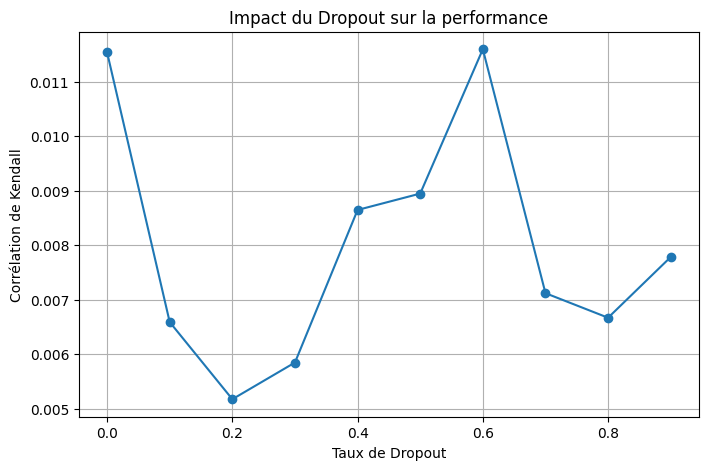

In [22]:
# Petit graphique pour visualiser
best_dropout = max(results_dropout, key=results_dropout.get) #Best value for future testing

plt.figure(figsize=(8, 5))
plt.plot(list(results_dropout.keys()), list(results_dropout.values()), marker='o')
plt.title("Impact du Dropout sur la performance")
plt.xlabel("Taux de Dropout")
plt.ylabel("Corrélation de Kendall")
plt.grid(True)
plt.show()

The dropout is slightly increasing the performance of the model in regards to the Kendall Correlation. We will chose 0.6 as our dropout parameter, this is confirming the high noise presence in our data.

### 7. Does using Adam's Clipnorm option improve performance during the test period?

Truncates each individual gradient element if it exceeds a certain absolute value. For example, if clipvalue=0.5, any gradient of 0.8 will become 0.5, and -1.2 will become -0.5.

Same as before, we find the best hyperparameter using gridsearch.

In [23]:
from tensorflow.keras.optimizers import Adam

In [26]:
clipnorm_grid = [0.1, 0.5, 1.0, 2.0, 5.0]
results_clip = {}

for clip_val in clipnorm_grid:
    print(f"\n--- Test with Clipnorm = {clip_val} ---")

    # Model
    inputs = Input(shape=(SEQ_LENGTH, N_ASSETS))
    x = LSTM(best_neurone_nb_lstm, activation='tanh', dropout=best_dropout, recurrent_dropout=best_dropout)(inputs)
    outputs = Dense(N_ASSETS, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam(learning_rate=0.01, clipnorm=clip_val) # Adam line
    model.compile(optimizer=opt, loss='mse')

    # Training
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=30,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[es],
              verbose=0) # Silence

    # Evaluation
    y_pred = model.predict(X_test, verbose=0)
    tau, _ = kendalltau(y_test.flatten(), y_pred.flatten())

    results_clip[clip_val] = tau
    print(f"-> Clipnorm {clip_val} : Kendall Tau = {tau:.5f}")


--- Test avec Clipnorm = 0.1 ---
-> Clipnorm 0.1 : Kendall Tau = 0.00624

--- Test avec Clipnorm = 0.5 ---
-> Clipnorm 0.5 : Kendall Tau = 0.00441

--- Test avec Clipnorm = 1.0 ---
-> Clipnorm 1.0 : Kendall Tau = 0.00820

--- Test avec Clipnorm = 2.0 ---
-> Clipnorm 2.0 : Kendall Tau = 0.00586

--- Test avec Clipnorm = 5.0 ---
-> Clipnorm 5.0 : Kendall Tau = 0.01351


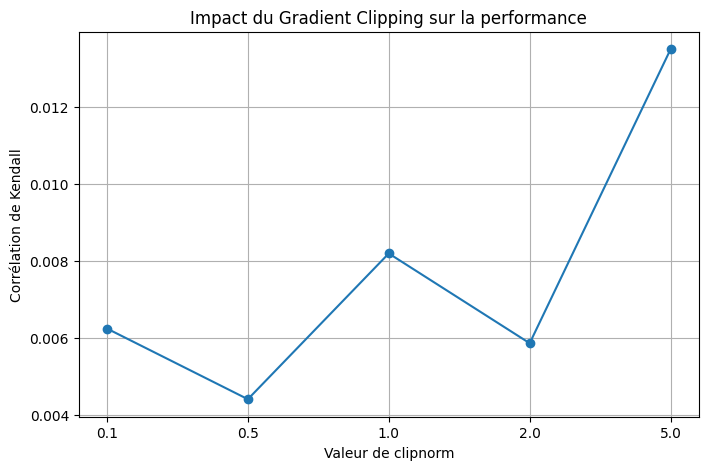

In [27]:
# Small graph for visualization
best_clip = max(results_clip, key=results_clip.get) #Best value for future testing

plt.figure(figsize=(8, 5))
plt.plot([str(c) for c in results_clip.keys()], list(results_clip.values()), marker='o')
plt.title("Impact of Gradient Clipping on Performance")
plt.xlabel("Clipnorm Value")
plt.ylabel("Kendall Correlation")
plt.grid(True)
plt.show()

Clipnorm is slightly increasing the performance of the model in regards to the Kendall Correlation when having clipnorm = 5.0

### 8. Same question for the ReduceLROnPlateau callback

Si l'erreur ne baisse plus pendant X époques (patience), on divise le Learning Rate par un facteur Y (factor). Cela permet au modèle d'affiner sa recherche (faire des petits pas) quand il est bloqué, et souvent de débloquer la situation pour gagner encore un peu de performance

We find the best hyperparameter Y for a 3 epoch patience using gridsearch.

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [29]:
factor_grid = [0.1, 0.2, 0.5, 0.7, 0.9]
results_factor = {}

for fact in factor_grid:
    print(f"\n--- Test with factor = {fact} ---")

    # Model
    inputs = Input(shape=(SEQ_LENGTH, N_ASSETS))
    x = LSTM(best_neurone_nb_lstm, activation='tanh', dropout=best_dropout, recurrent_dropout=best_dropout)(inputs)
    outputs = Dense(N_ASSETS, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam(learning_rate=0.001, clipnorm=best_clip)
    model.compile(optimizer=opt, loss='mse')

    # Training
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # The ReduceLROnPlateau we are testing
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=fact,
                                  patience=3,
                                  min_lr=1e-6,
                                  verbose=0)

    model.fit(X_train, y_train,
              epochs=40,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[es, reduce_lr],
              verbose=0) # Silence

    # Evaluation
    y_pred = model.predict(X_test, verbose=0)
    tau, _ = kendalltau(y_test.flatten(), y_pred.flatten())

    results_factor[fact] = tau
    print(f"-> Factor {fact} : Kendall Tau = {tau:.5f}")


--- Test avec factor = 0.1 ---
-> Factor 0.1 : Kendall Tau = 0.00721

--- Test avec factor = 0.2 ---
-> Factor 0.2 : Kendall Tau = 0.01028

--- Test avec factor = 0.5 ---
-> Factor 0.5 : Kendall Tau = 0.01006

--- Test avec factor = 0.7 ---
-> Factor 0.7 : Kendall Tau = 0.01106

--- Test avec factor = 0.9 ---
-> Factor 0.9 : Kendall Tau = 0.01166


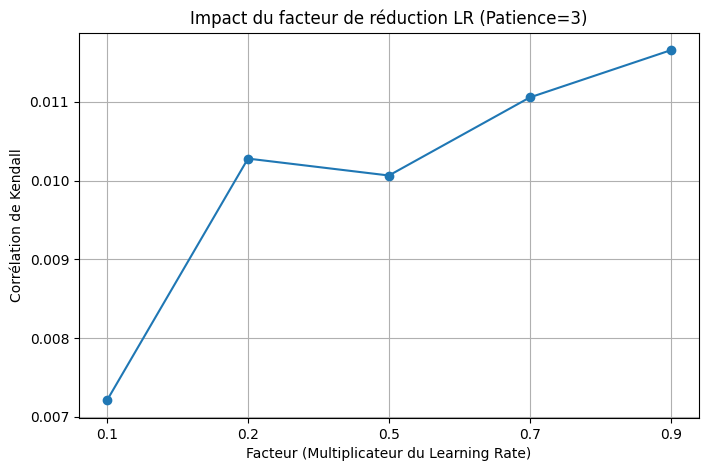

In [30]:
# Small graph for visualization
best_fact = max(results_factor, key=results_factor.get) #Best value for future testing

plt.figure(figsize=(8, 5))
plt.plot([str(f) for f in results_factor.keys()], list(results_factor.values()), marker='o')
plt.title("Impact of LR Reduction Factor (Patience=3)")
plt.xlabel("Factor (Learning Rate Multiplier)")
plt.ylabel("Kendall Correlation")
plt.grid(True)
plt.show()

Callback is decreasing the overall performance of the model in regards to the Kendall Correlation. I decided to no keep it in the rest of the lab.

### 9. Same question as a function of N.

In [31]:
n_assets_grid = [10, 50, 100, 200, 328]
results_n = {}

for n in n_assets_grid:
    print(f"\n--- Test avec N = {n} actifs ---")

    # Data Preparation
    data_subset = df_filled.iloc[:LIMIT, :n].values.astype('float32')
    X_n, y_n = create_sequences(data_subset, SEQ_LENGTH)

    # Split Train/Val/Test (80% / 20%)
    split_idx = int(len(X_n) * 0.8)
    X_train_n, X_val_n = X_n[:split_idx], X_n[split_idx:]
    y_train_n, y_val_n = y_n[:split_idx], y_n[split_idx:]

    test_start = LIMIT - SEQ_LENGTH
    data_test = df_filled.iloc[test_start:, :n].values.astype('float32')
    X_test_n, y_test_n = create_sequences(data_test, SEQ_LENGTH)

    # Model
    inputs = Input(shape=(SEQ_LENGTH, n))
    x = LSTM(64, activation='tanh', dropout=0.6, recurrent_dropout=0.6)(inputs)
    outputs = Dense(n, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=opt, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)

    # Training
    model.fit(X_train_n, y_train_n,
              epochs=40,
              batch_size=32,
              validation_data=(X_val_n, y_val_n),
              callbacks=[es, reduce_lr],
              verbose=0) # Silence

    # Evaluation
    y_pred_n = model.predict(X_test_n, verbose=0)
    tau, _ = kendalltau(y_test_n.flatten(), y_pred_n.flatten())

    results_n[n] = tau
    print(f"-> N={n} : Kendall Tau = {tau:.5f}")


--- Test avec N = 10 actifs ---
-> N=10 : Kendall Tau = 0.01146

--- Test avec N = 50 actifs ---
-> N=50 : Kendall Tau = 0.00758

--- Test avec N = 100 actifs ---
-> N=100 : Kendall Tau = 0.00988

--- Test avec N = 200 actifs ---
-> N=200 : Kendall Tau = 0.01460

--- Test avec N = 328 actifs ---
-> N=328 : Kendall Tau = 0.00950


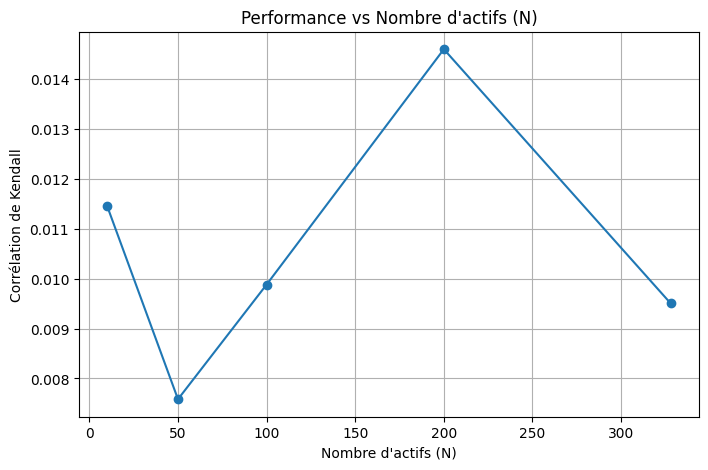

In [32]:
# Small graph for visualization
plt.figure(figsize=(8, 5))
plt.plot(list(results_n.keys()), list(results_n.values()), marker='o')
plt.title("Performance vs Number of Assets (N)")
plt.xlabel("Number of Assets (N)")
plt.ylabel("Kendall Correlation")
plt.grid(True)
plt.show()

We observe than the Kendall Corelation is maximised for 200 tickers.

## II. Rolling calibrations vs. stationarization

### 1. Extend the test window to cover all remaining time steps. Plot the prediction performance over time for a model with and without a RevIN layer (you can keep the rest of the options that appeared most effective to you).

We first evaluate the performance of a stationary model, we train it on a given time period et inspect its performance on a future time period. For performance standpoint, I decided to use a GRU model with 256 neurones, à 0.6 dropout, 0.5 Clipnorm, N = 200 and no Callback. See previous testing but this time with GRU.

In [53]:
# Parametres
N_NEURONS = 256
DROPOUT = 0.6
CLIPNORM = 0.5
N_ASSETS = 200
SEQ_LENGTH = 20
LIMIT = 1000
MODEL_TYPE = 'GRU'

In [54]:
class RevIN(Layer):
    def __init__(self, num_features, eps=1e-5, affine=True, **kwargs):
        super(RevIN, self).__init__(**kwargs)
        self.num_features = num_features
        self.eps = eps
        self.affine = affine

    def build(self, input_shape):
        if self.affine:
            self.affine_weight = self.add_weight(name='affine_weight',
                                               shape=(1, self.num_features),
                                               initializer='ones',
                                               trainable=True)
            self.affine_bias = self.add_weight(name='affine_bias',
                                             shape=(1, self.num_features),
                                             initializer='zeros',
                                             trainable=True)
        super(RevIN, self).build(input_shape)

    def call(self, x, mode='norm', mean_input=None, std_input=None):
        if mode == 'norm':
            mean = tf.reduce_mean(x, axis=1, keepdims=True)
            stdev = tf.math.reduce_std(x, axis=1, keepdims=True) + self.eps
            x_normalized = (x - mean) / stdev
            if self.affine:
                x_normalized = x_normalized * self.affine_weight + self.affine_bias
            return x_normalized, mean, stdev # Return all three values

        elif mode == 'denorm':
            if mean_input is None or std_input is None:
                raise ValueError("mean_input and std_input must be provided for 'denorm' mode.")

            # Reverse affine transformation first
            if self.affine:
                x_denorm = (x - self.affine_bias) / (self.affine_weight + self.eps)
            else:
                x_denorm = x

            # Reverse normalization
            mean_squeezed = tf.squeeze(mean_input, axis=1) # mean_input is (Batch, 1, N), squeeze to (Batch, N)
            std_squeezed = tf.squeeze(std_input, axis=1)   # std_input is (Batch, 1, N), squeeze to (Batch, N)

            return (x_denorm * std_squeezed) + mean_squeezed
        return x


In [55]:
# Data Preparation
# Use the entire df_filled but only N_ASSETS columns for X_full and y_full
full_data_for_sequences = df_filled.iloc[:, :N_ASSETS].values.astype('float32')
X_full, y_full = create_sequences(full_data_for_sequences, SEQ_LENGTH)

# Split Train (0 to LIMIT) / Long Test (LIMIT to end)
# Adjust LIMIT to account for SEQ_LENGTH in sequence creation
# The first LIMIT rows of original data become `LIMIT - SEQ_LENGTH` samples after sequence creation.
train_end_idx = LIMIT - SEQ_LENGTH # The index in X_full where the initial training data ends

X_train = X_full[:train_end_idx]
y_train = y_full[:train_end_idx]
X_long_test = X_full[train_end_idx:]
y_long_test = y_full[train_end_idx:]

# Split Validation (20% of train for early stopping)
split_val = int(len(X_train) * 0.8)
X_train_sub, X_val = X_train[:split_val], X_train[split_val:]
y_train_sub, y_val = y_train[:split_val], y_val[split_val:]


# Models
def build_model(use_revin=False):
    inputs = Input(shape=(SEQ_LENGTH, N_ASSETS))

    # Normalization (if use_revin = True)
    if use_revin:
        revin_layer = RevIN(num_features=N_ASSETS)
        x, mean, std = revin_layer(inputs, mode='norm') # RevIN layer returns mean and std
    else:
        x = inputs


    x = GRU(N_NEURONS, activation='tanh', dropout=DROPOUT, recurrent_dropout=DROPOUT)(x)
    x = Dense(N_ASSETS, activation='linear')(x)

    # Denormalization (if use_revin = True)
    if use_revin:
        outputs = revin_layer(x, mode='denorm', mean_input=mean, std_input=std)
    else:
        outputs = x

    model = Model(inputs=inputs, outputs=outputs)

    # Optimizer with Clipnorm
    opt = Adam(learning_rate=0.001, clipnorm=CLIPNORM)
    model.compile(optimizer=opt, loss='mse')
    return model

# Training
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model A: Without RevIN (Standard)
model_a = build_model(use_revin=False)
print("Training Model A (Standard GRU without RevIN)")
model_a.fit(X_train_sub, y_train_sub, validation_data=(X_val, y_val),
            epochs=40, batch_size=32, callbacks=[es], verbose=1)

# Model B: With RevIN
model_b = build_model(use_revin=True)
print("\nTraining Model B (GRU with RevIN)")
model_b.fit(X_train_sub, y_train_sub, validation_data=(X_val, y_val),
            epochs=40, batch_size=32, callbacks=[es], verbose=1)

Training Model A (Standard GRU without RevIN)
Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 9.9094e-04 - val_loss: 0.0011
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.1587e-04 - val_loss: 0.0011
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.7502e-04 - val_loss: 0.0011
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 8.4382e-04 - val_loss: 0.0011
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 8.5331e-04 - val_loss: 0.0011
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 9.1337e-04 - val_loss: 0.0011
Epoch 10/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 8.4154e-04 - val_loss: 0.0011
Epoch 11/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 8.7549e-04 - va

In [56]:
# Prediction
pred_a = model_a.predict(X_long_test, verbose=0)
pred_b = model_b.predict(X_long_test, verbose=0)

# Calculate rolling Kendall correlation
window = 250
step = 50
taus_a, taus_b, timeline = [], [], []

for t in range(0, len(y_long_test) - window, step):
    y_true_w = y_long_test[t : t+window].flatten()
    pred_a_w = pred_a[t : t+window].flatten()
    pred_b_w = pred_b[t : t+window].flatten()

    ta, _ = kendalltau(y_true_w, pred_a_w)
    tb, _ = kendalltau(y_true_w, pred_b_w)

    taus_a.append(ta)
    taus_b.append(tb)
    timeline.append(t)

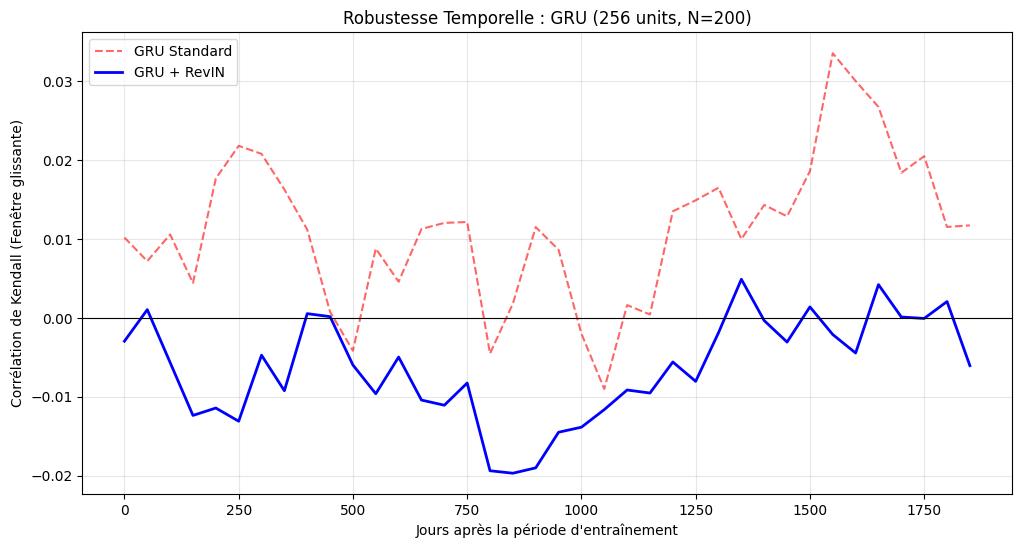

In [57]:
# Graph
plt.figure(figsize=(12, 6))
plt.plot(timeline, taus_a, label=f'{MODEL_TYPE} Standard', linestyle='--', color='red', alpha=0.6)
plt.plot(timeline, taus_b, label=f'{MODEL_TYPE} + RevIN', color='blue', linewidth=2)
plt.axhline(0, color='black', linewidth=0.8)
plt.title(f"Temporal Robustness : {MODEL_TYPE} ({N_NEURONS} units, N={N_ASSETS})")
plt.xlabel("Days after training period")
plt.ylabel("Kendall Correlation (Rolling Window)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

We observe that the model not using the RevIn is nearly always more performant, it is certainly due to the very low ratio signal/noise. The standard GRU display very good Kendall corelation (around 0.18)

### 2. Wrap the previous code in a loop that shifts the train/val/test windows and trains an RNN each time. Plot the performance within the test windows.

We will now use cross validation with sliding windows.

In [58]:
# Parameters
TRAIN_WINDOW = 1000
TEST_WINDOW = 200
STEP = 200

# Lists to store results
rolling_taus = []
rolling_dates = []

# Get the total size of available data
total_samples = len(X_full)

# Loop
# Stop when a complete Train + Test block can no longer be formed
for t in range(0, total_samples - TRAIN_WINDOW - TEST_WINDOW + 1, STEP):

    # Definition of temporal indices
    train_start = t
    train_end = t + TRAIN_WINDOW
    test_end = train_end + TEST_WINDOW

    print(f"\n--- Iteration : Train [{train_start}:{train_end}] -> Test [{train_end}:{test_end}] ---")

    # Data splitting
    # Train
    X_train_roll = X_full[train_start : train_end]
    y_train_roll = y_full[train_start : train_end]

    # Internal Train/Val Split for EarlyStopping (80/20)
    split = int(len(X_train_roll) * 0.8)
    X_tr, X_va = X_train_roll[:split], X_train_roll[split:]
    y_tr, y_va = y_train_roll[:split], y_train_roll[split:]

    # Test (the next period)
    X_test_roll = X_full[train_end : test_end]
    y_test_roll = y_full[train_end : test_end]

    # Model (start from scratch each time)
    model_rolling = build_model(use_revin=False)

    # Training
    model_rolling.fit(X_tr, y_tr,
                      validation_data=(X_va, y_va),
                      epochs=30,
                      batch_size=32,
                      callbacks=[es], # Keep EarlyStopping
                      verbose=0)

    # Evaluation
    y_pred_roll = model_rolling.predict(X_test_roll, verbose=0)
    tau, _ = kendalltau(y_test_roll.flatten(), y_pred_roll.flatten())

    rolling_taus.append(tau)
    rolling_dates.append(train_end) # Store the prediction start date

    print(f"-> Kendall Tau: {tau:.5f}")


--- Itération : Train [0:1000] -> Test [1000:1200] ---
-> Kendall Tau: 0.02077

--- Itération : Train [200:1200] -> Test [1200:1400] ---
-> Kendall Tau: 0.00292

--- Itération : Train [400:1400] -> Test [1400:1600] ---
-> Kendall Tau: 0.02110

--- Itération : Train [600:1600] -> Test [1600:1800] ---
-> Kendall Tau: 0.01515

--- Itération : Train [800:1800] -> Test [1800:2000] ---
-> Kendall Tau: 0.00523

--- Itération : Train [1000:2000] -> Test [2000:2200] ---
-> Kendall Tau: 0.03311

--- Itération : Train [1200:2200] -> Test [2200:2400] ---
-> Kendall Tau: 0.00569

--- Itération : Train [1400:2400] -> Test [2400:2600] ---
-> Kendall Tau: 0.03218

--- Itération : Train [1600:2600] -> Test [2600:2800] ---
-> Kendall Tau: 0.00394

--- Itération : Train [1800:2800] -> Test [2800:3000] ---
-> Kendall Tau: 0.00230


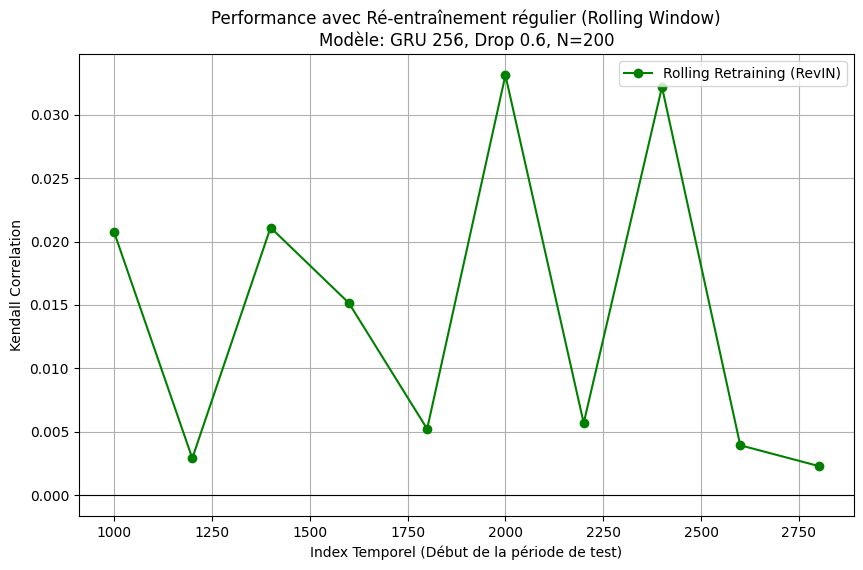

In [59]:
# Graph
plt.figure(figsize=(10, 6))
plt.plot(rolling_dates, rolling_taus, marker='o', linestyle='-', color='green', label='Rolling Retraining (RevIN)')
plt.axhline(0, color='black', linewidth=0.8)
plt.title(f"Performance with Regular Retraining (Rolling Window)\nModel: GRU 256, Drop 0.6, N={N_ASSETS}")
plt.xlabel("Time Index (Start of Test Period)")
plt.ylabel("Kendall Correlation")
plt.legend()
plt.grid(True)
plt.show()

### 3. Compare the performance between points 1 and 2. Are they statistically significantly different? Which figure from the lecture can shed light on your interpretation?

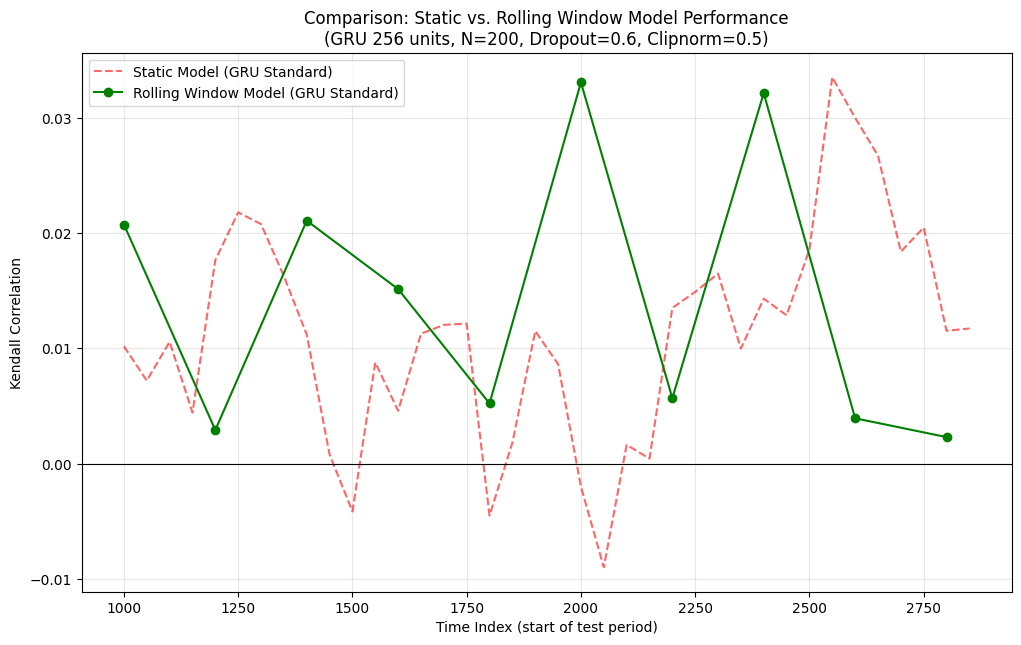


Average Kendall Correlation (Static Model): 0.01125
Average Kendall Correlation (Rolling Window Model): 0.01424


In [61]:
# Compare static model performance with rolling window performance

plt.figure(figsize=(12, 7))

# Recreate timeline for the static model prediction over X_long_test
static_timeline = []
for t in range(0, len(y_long_test) - window, step):
    static_timeline.append(t + LIMIT)

plt.plot(static_timeline, taus_a[:len(static_timeline)], label='Static Model (GRU Standard)', linestyle='--', color='red', alpha=0.6)

plt.plot(rolling_dates, rolling_taus, marker='o', linestyle='-', color='green', label='Rolling Window Model (GRU Standard)')
plt.axhline(0, color='black', linewidth=0.8)
plt.title(f"Comparison: Static vs. Rolling Window Model Performance\n(GRU {N_NEURONS} units, N={N_ASSETS}, Dropout={DROPOUT}, Clipnorm={CLIPNORM})")
plt.xlabel("Time Index (start of test period)")
plt.ylabel("Kendall Correlation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAverage Kendall Correlation (Static Model): {np.mean(taus_a):.5f}")
print(f"Average Kendall Correlation (Rolling Window Model): {np.mean(rolling_taus):.5f}")


We observe that the model using a rolling window cross validation statistically shows much better result that the model without. This is because the first model have fresher information that are more likely corelated to the target than older returns.

In other words, this is due to the non-stationarity of the market returns. The markets paterns and mechanisms are changing overtime. The figure slide 51 can shed light on this result.